In [14]:
# 1. Librerías necesarias
import os
import tarfile
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


In [15]:
# 2. Descomprimir el archivo .tar.gz
dataset_path = 'speech_commands_v0.02.tar.gz'
extract_path = 'speech_commands_v0.02'

if not os.path.exists(extract_path):
    with tarfile.open(dataset_path, 'r:gz') as tar:
        tar.extractall(path=extract_path)
    print("Dataset extraído correctamente.")
else:
    print("El dataset ya está extraído.")

C:\Users\User\AppData\Local\Temp\ipykernel_4144\286215404.py:7: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Dataset extraído correctamente.


In [16]:
# 3. Definir rutas de las carpetas 'yes' y 'no'
yes_folder = os.path.join(extract_path, 'yes')
no_folder = os.path.join(extract_path, 'no')

# 4. Función para convertir audio a espectrograma
def audio_to_spectrogram(file_path):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

In [18]:
# 5. Cargar y convertir audios
spectrograms = []
labels = []

for label, folder in enumerate([no_folder, yes_folder]):  # 0: no, 1: yes
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if file_path.endswith('.wav'):
            try:
                spec = audio_to_spectrogram(file_path)
                spectrograms.append(spec)
                labels.append(label)
            except Exception as e:
                print(f"Error procesando {file_path}: {e}")



In [19]:
# 6. Preparar los datos (corregido)
import tensorflow as tf
import numpy as np

# Definir una forma fija para todos los espectrogramas (por ejemplo, 128x128)
target_shape = (128, 128)

# Redimensionar todos los espectrogramas a la misma forma
spectrograms_resized = np.array([
    tf.image.resize(spec[..., np.newaxis], size=target_shape).numpy().squeeze()
    for spec in spectrograms
])

# Añadir canal para CNN
X = spectrograms_resized[..., np.newaxis]
y = np.array(labels)

print("Forma de los espectrogramas:", X.shape)
print("Forma de las etiquetas:", y.shape)


Forma de los espectrogramas: (7985, 128, 128, 1)
Forma de las etiquetas: (7985,)


In [20]:
# 7. Redimensionar espectrogramas para que tengan la misma forma
# Usamos la forma del espectrograma más grande como referencia
max_shape = max([spec.shape for spec in spectrograms], key=lambda x: x[1])
spectrograms_resized = np.array([
    tf.image.resize(spec[..., np.newaxis], size=max_shape).numpy().squeeze()
    for spec in spectrograms
])

# Añadir canal para CNN
X = spectrograms_resized[..., np.newaxis]
y = labels



In [22]:
# 8. Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir y_train e y_test a numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# 9. Construir el modelo
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Clasificación binaria
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 10. Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# 11. Evaluar el modelo
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.2f}")

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8098 - loss: 1.8543 - val_accuracy: 0.9580 - val_loss: 0.1110
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9609 - loss: 0.1010 - val_accuracy: 0.9681 - val_loss: 0.0840
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9741 - loss: 0.0676 - val_accuracy: 0.9762 - val_loss: 0.0555
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9790 - loss: 0.0457 - val_accuracy: 0.9768 - val_loss: 0.0612
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9818 - loss: 0.0443 - val_accuracy: 0.9787 - val_loss: 0.0539
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9888 - loss: 0.0291 - val_accuracy: 0.9750 - val_loss: 0.0676
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9867 - loss: 0.0291 - val_accuracy: 0.9762 - val_loss: 0.0694
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9880 - loss: 0.0308 - val_accu

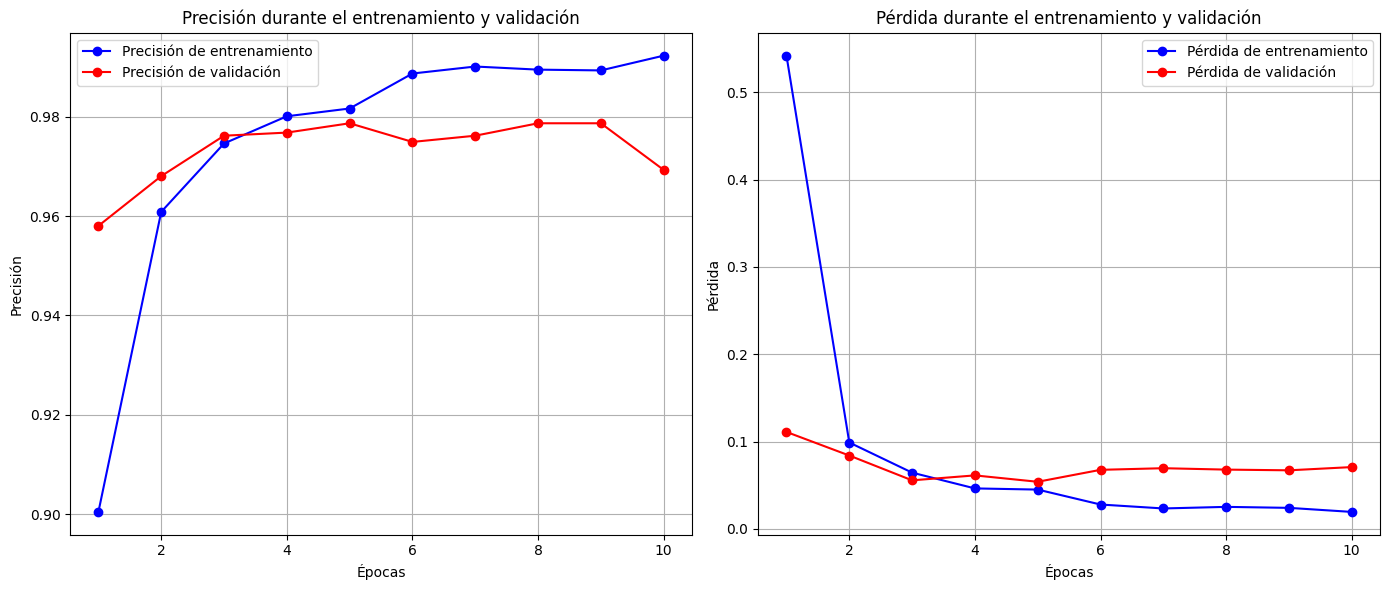

In [24]:
import matplotlib.pyplot as plt

# Función para graficar la evolución del entrenamiento
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Gráfica de precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Precisión de entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Precisión de validación')
    plt.title('Precisión durante el entrenamiento y validación')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)

    # de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Pérdida de entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Pérdida de validación')
    plt.title('Pérdida durante el entrenamiento y validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Llamar a la función después de entrenar el modelo
plot_training_history(history)
